# Rejection Sampling

Is a type of exact simulation method. The method works for any distribution in $\mathbf{R}^n$ with a PDF.

Rejection sampling is based on the observation that to sample a random variable in one dimension, one can perform a uniformly random sampling of the two-dimensional Cartesian graph, and keep the samples in the region under the graph of its density function.

First we need a source of random numbers uniformly distributed between 0 and 1.
Given a source of random numbers with such a uniform distribution, we can easily produce a random sequence
with an arbitrary distribution.
Suppose we have a positive function $f(x)$ on the unit interval and we wish to generate points with a weighting proportional to
$f$.
For simplicity assume $f$ is bounded; if not, make a change of variables to make it so.
Without logg of generality, we assume $f(x)$ us bounded by unity.
Using the given random number generator, we obtains a trial number for the first element of our weighted sequence.
Calling this number $x$, we obtain a second random number and accept $x$ if the new random variable is less than $f(x)$.
This is repeated many times to form a sequence of accepted values of $x$.
As the probability of accepting any $x$ is proportional to $f(x)$, the sequence has the desired weighting.

From "Quarks, Gluons, and Lattice", page 132.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import uniform

In [2]:
%%timeit # -r 7 -n 1_000
s = np.random.uniform(0, 1, 100_000)

414 µs ± 3.79 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


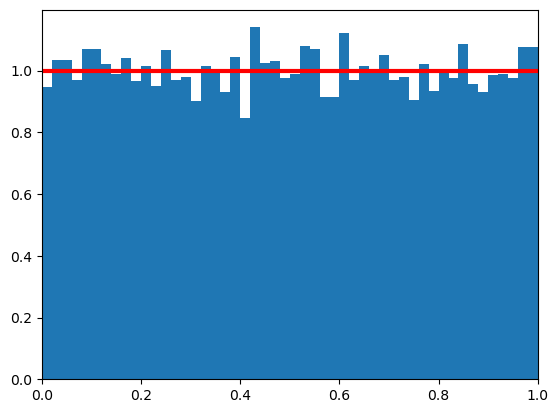

In [5]:
s = np.random.uniform(0, 1, 10_000)

count, bins, ignored = plt.hist(s, 50, density=True)

plt.plot(bins, np.ones_like(bins), linewidth=3, color='r')
plt.xlim(0, 1)
plt.show()

In [28]:
from scipy.stats import norm

sample = np.random.uniform(0, 1, 1000)

In [32]:
approximation = []
for u in sample:
    if u < norm.cdf(u):
        approximation.append(u)

In [33]:
len(approximation)

783

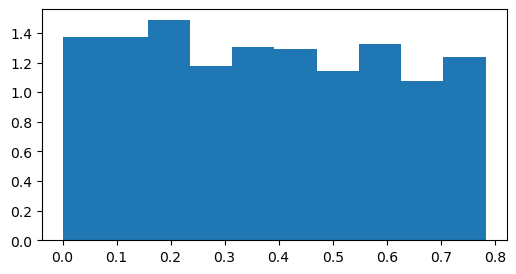

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 200)
#ax.plot(x, norm.pdf(x), 'r-', lw=5, alpha=0.9, label="norm pdf")

ax.hist(approximation, bins=10, density=True)

#ax.legend(loc='best', frameon=False)
fig.show()